In [632]:
# Supress unnecessary warning messages

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [923]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from collections import Counter
from copy import deepcopy
from fancyimpute import MICE
from datetime import datetime
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [961]:
with open('./data/raw/user_subset.pkl', 'rb') as picklefile:
    user = pickle.load(picklefile)
with open('./data/raw/session_subset.pkl', 'rb') as picklefile:
    session = pickle.load(picklefile)

In [962]:
def drop_rare_values(df, threshold):
    df_obj = df.select_dtypes(include='object').iloc[:,1:]
    for column in df_obj.columns:
        levels = df[column].value_counts()/df.shape[0]
        insig_index = np.sum([x > threshold for x in levels.tolist()])
        for i in range(insig_index, levels.shape[0]):
            value = levels.index.tolist()[i]
            df[column].replace(value, 'catchall', inplace=True)
    return df

## Format and split user data

In [963]:
# Impute the missing action_type and action_details with mode values
def impute_mode(df, col_key, col_na, mode_table=None):
    
    if (mode_table is None):
        mode_series = df[~df[col_na].isna()].groupby(col_key)[col_na].agg(lambda x:x.value_counts().index[0])
        mode_series = pd.DataFrame(mode_series.reset_index())
        mode_table = mode_series
    else:
        mode_series = mode_table
    merged_frame = pd.merge(df, mode_series, how='left', 
                             left_on=[col_key], 
                             right_on=[col_key]).set_index(df.index)
    
    merged_frame.rename(columns={col_na+'_x': col_na, col_na+'_y':'mode_value'}, inplace=True)
    merged_frame[col_na].fillna(merged_frame.mode_value, inplace=True)
    merged_frame.drop(['mode_value'], axis=1, inplace=True)
    
    return merged_frame, mode_table

In [964]:
def date_transformation(user):
    user['date_account_created'] = pd.to_datetime(user['date_account_created'], format='%Y-%m-%d')
    user['timestamp_first_active'] = pd.to_datetime(user['timestamp_first_active']//10000, format='%Y%m%d%H')
    user.drop('date_first_booking', axis=1, inplace=True)
    #user['account_age'] = user['date_account_created'].apply(lambda x:(x.year-1970)*12+x.month)
    user['create_year'] = user['date_account_created'].apply(lambda x:x.year)
    user['create_month'] = user['date_account_created'].apply(lambda x:x.month)
    
    #user['active_age'] = user['timestamp_first_active'].apply(lambda x:(x.year-1970)*12+x.month)
    user['active_year'] = user['timestamp_first_active'].apply(lambda x:x.year)
    user['active_month'] = user['timestamp_first_active'].apply(lambda x:x.month)
    user['active_hour'] = user['timestamp_first_active'].apply(lambda x:x.hour)
    
    user['signup_flow'] = user['signup_flow'].astype(int).astype('str')

    y_user = pd.DataFrame(user['country_destination'].values, columns=['country_destination'], index=user.id)
    X_user = user.drop(['country_destination'], axis=1)
    X_user.set_index('id', inplace=True)
    return X_user, y_user

## Deal with wrong and missing values in user data

In [965]:
def impute_age(X_user_train, age_mode=None):
    X_user_train.first_affiliate_tracked.fillna('catchall', inplace=True)
    X_user_train.loc[((X_user_train['age'] <= 18) | (X_user_train['age'] >= 100)), 'age' ] = np.NAN
    cols_to_drop = ['date_account_created', 'timestamp_first_active']
    X_user_train.drop(cols_to_drop, axis=1, inplace=True)

    # Imput data with median value
    # median_age = X_user_train[~X_user_train['age'].isna()].age.median()
    # X_user_train.loc[X_user_train['age'].isna(), 'age'] = median_age
    
    X_user_train, train_age_mode = impute_mode(X_user_train, 'first_device_type', 'age', age_mode)

    return X_user_train, train_age_mode

In [966]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude='object')
    # print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in sorted(list(levels.index)):
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [967]:
X_user, y_user = date_transformation(user)
user = drop_rare_values(user, 0.005)
X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(X_user, y_user, test_size = 0.25, random_state=1234, stratify=y_user)
X_user_train, train_age_mode = impute_age(X_user_train)
X_user_train, user_train_cols = custom_dummify(X_user_train, 0.005)
X_user_train.drop('signup_flow_1', axis=1, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

## Deal with wrong and missing values in session data


In [979]:
def impute_session(session_train):
    # Replace NaN in action column with others
    session_train['action'].fillna("catch-all", inplace=True)
    # Clip the sessions longer than 24 hours to 24 hours
    session_train.loc[session_train['secs_elapsed']>24*3600, 'secs_elapsed'] = 24*3600
    return session_train

In [980]:
def get_session_cat_stats(user_df, session_df):
    session_stats = pd.DataFrame(index=user_df.index)
    cat_cols = list(session_df.select_dtypes(include='object').columns)[1:]
    
    for col in cat_cols:
        val_freq = Counter(session_df[col])
        sig_val = sorted(list(val_freq.keys()))

        for val in sig_val:
            val_count = session_df.groupby(session_df.index).apply(lambda x, val=val, col=col: np.sum(x[col] == val))
            tmp = pd.DataFrame(val_count.values, columns=[col+'['+val+']'], index=val_count.index)
            session_stats = pd.merge(session_stats, tmp, how='left', left_index=True, right_index=True )
    return session_stats

In [981]:
session = drop_rare_values(session, 0.005)

session.set_index('user_id', drop=False, inplace=True)
train_index = list(X_user_train.index)
session_train = session[session['user_id'].isin(train_index)]
test_index = list(X_user_test.index)
session_test = session[session['user_id'].isin(test_index)]

session_train = impute_session(session_train)
session_test = impute_session(session_test)
session_train, action_type_mode = impute_mode(session_train, 'action', 'action_type')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'action_detail')
session_train, action_secs_mode = impute_mode(session_train, 'action', 'secs_elapsed')
session_train.fillna("catch-all", inplace=True)
session_stats = get_session_cat_stats(X_user_train, session_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
with open('./data/processed/session_stats.pkl', 'wb') as picklefile:
    pickle.dump(session_stats, picklefile)

## Combine session and user data

In [982]:
def quantile_range(x):
    return x.quantile(0.75)-x.quantile(0.25)

In [983]:
def get_session_continous_stats(user_df, session_df):
    session_sec_stats = session_df.groupby('user_id')['secs_elapsed'].agg([np.median, np.mean, np.std, skew, kurtosis, quantile_range])
    session_sec_stats.rename(columns={'median':'sess[median]', 'mean':'sess[mean]', 'std':'sess[std]', 'skew':'sess[skew]', 'kurtosis':'sess[kurtosis]', 'quan_range':'sess[quan_range]'}, inplace=True)
    user_df = user_df.merge(session_sec_stats, how='left', left_index=True, right_index=True)
    return user_df

In [984]:
X_user_train_1 = deepcopy(X_user_train)
X_user_train_1 = X_user_train_1.merge(session_stats, how='left', left_index=True, right_index=True)
X_user_train_1 = get_session_continous_stats(X_user_train_1, session_train)
X_user_train_1.fillna(0.0, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


## Build a baseline model for NDF and Booking

In [985]:
y_bin = deepcopy(y_user_train)
y_bin['booking'] = 1 - (y_bin['country_destination'] == 'NDF').astype('int')
y_bin.drop(['country_destination'], axis=1, inplace=True)
y_train=y_bin

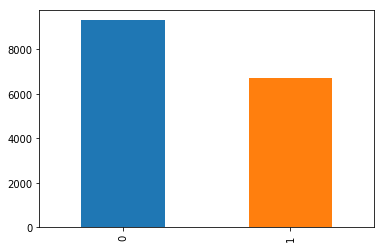

In [986]:
y_train['booking'].value_counts().plot('bar')

In [987]:
ssX = StandardScaler()
X_train_imputed_scaled = ssX.fit_transform(X_user_train_1)

In [991]:
models = [
          ('logistic', LogisticRegression),
          #('tree', DecisionTreeClassifier),
          #('forest', RandomForestClassifier),
          #('xgboost', XGBClassifier)
         ]

param_choices = [    
    {
        'C': np.logspace(-3, 6, 12),
        'penalty': ['l1', 'l2']
    },
    
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },

    {
        'criterion':['gini','entropy'],
        'n_estimators': [40,50,60],
        'min_samples_leaf':[1,3],
        'min_samples_split':[2,5]
    },    

    {
        'max_depth': [5,6,7],
        'learning_rate': np.logspace(-2,0,5),
        'n_estimators': [80,90,85,95],
        'objective':['binary:logistic']
    }
]


grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = RandomizedSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_train_imputed_scaled, y_train)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids[name] = grid

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

logistic: best score: 0.6747251374312844


In [992]:
#print (grids['forest'].best_score_)
print (grids['logistic'].best_score_)
print (grids['logistic'].best_params_)

0.6747251374312844
{'penalty': 'l2', 'C': 151991.10829529332}


logistic:
0.6685407296351824
{'penalty': 'l1', 'C': 1.873817422860385}

**Result-Accuracy**<br>
knn: best score: 0.6414292853573214 <br>
logistic: best score: 0.6689780109945027 <br>
tree: best score: 0.698088455772114 <br>
forest: best score: 0.6454897551224388 <br>

**Result-AUC**<br>
knn: best score: 0.6797561404771426<br>
logistic: best score: 0.7137787331059189<br>
tree: best score: 0.7405620278725061<br>
forest: best score: 0.731510519720228<br>


**Result-AUC**<br>
knn: best score: 0.659525884390658<br>
logistic: best score: 0.7141040998794065<br>
tree: best score: 0.722326283870917<br>
forest: best score: 0.7526480939542807<br>
{'criterion': 'gini',<br>
 'min_samples_leaf': 3,<br>
 'min_samples_split': 7,<br>
 'n_estimators': 100}<br>
xgboost: best score: 0.7654377067200799<br>
{'learning_rate': 0.1778279410038923,<br>
 'max_depth': 5,<br>
 'n_estimators': 80,<br>
 'objective': 'binary:logistic'}<br>
 
 models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier),
          ('svc', SVC )
         ]

param_choices = [
    {
        'n_neighbors': range(3, 9, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },
    {
        'criterion':['gini','entropy'],
        'n_estimators': [10, 20, 50, 100],
        'min_samples_leaf':[1,3,5],
        'min_samples_split':[2,5,7]
    },
    {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['binary:logistic']
    },
    {
        'kernal': ['poly', 'rbf'],
        'degree': np.linspace(2, 8, 7), 
        'C': np.linspace(0.1, 10, 5)
    }
]

only values >1% <br>
logistic: best score: 0.6645427286356822<br>
tree: best score: 0.6787856071964018<br>
forest: best score: 0.6893428285857072<br>
xgboost: best score: 0.6954647676161919<br>
{'learning_rate': 0.03162277660168379, <br>
 'max_depth': 5, <br>
 'n_estimators': 100, <br>
 'objective': 'binary:logistic'} <br>

In [993]:
grids['logistic'].best_params_

{'C': 151991.10829529332, 'penalty': 'l2'}

In [1004]:
y_train_pred = grids['logistic'].predict(X_train_imputed_scaled)
y_train_pred_soft = grids['logistic'].predict_proba(X_train_imputed_scaled)

In [1005]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

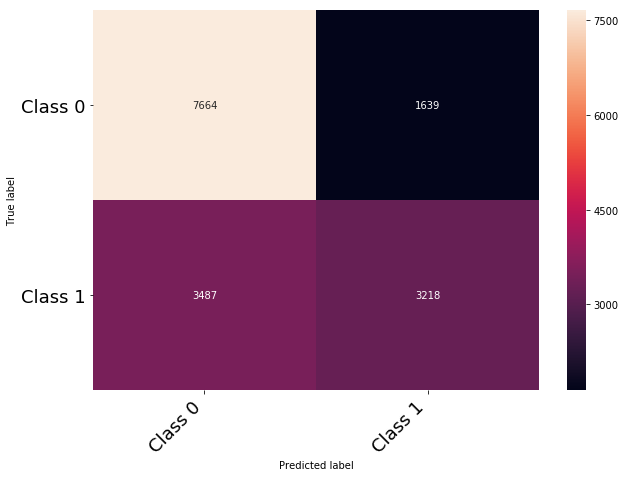

In [1006]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

## Incporate prediction and seggregate y into sub-categories

In [1007]:
X_train_stage2 = deepcopy(X_train_imputed_scaled)
X_train_2nd = np.append(X_train_stage2, y_train_pred_soft, axis=1)

In [476]:
#y_multi = set(deepcopy(y_user_train.to_list()))
NorAm = ['US', 'CA']
NDF = ['NDF']
EU = ['FR', 'IT', 'DE', 'ES', 'GB', 'PT', 'NL']
Other = ['AU', 'other']
y_mul = deepcopy(y_user_train)
y_mul.loc[y_mul['country_destination'].isin(NorAm), 'region'] = 'NorAM'
y_mul.loc[y_mul['country_destination'].isin(NDF), 'region'] = 'NDF'
y_mul.loc[y_mul['country_destination'].isin(EU), 'region'] = 'EU'
y_mul.loc[y_mul['country_destination'].isin(Other), 'region'] = 'Other'
y_mul = y_mul.region

In [477]:
rus = RandomUnderSampler()
X_train_down, y_train_down = rus.fit_sample(X_train_2nd,y_mul)

In [276]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train_down)
labels = encoder.transform(y_train_down)

In [289]:
models = [
          ('xgboost', XGBClassifier),
         ]

param_choices = [
    {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['multi:softprob']
    },
]


grids2 = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_train_down, labels)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids2[name] = grid

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

xgboost: best score: 0.3845926800472255


In [319]:
grids2['xgboost'].best_params_

{'learning_rate': 0.03162277660168379,
 'max_depth': 3,
 'n_estimators': 80,
 'objective': 'multi:softprob'}

In [ ]:
{'learning_rate': 0.03162277660168379,
 'max_depth': 3,
 'n_estimators': 80,
 'objective': 'multi:softprob'}
(453+714+108+224)/len(labels)

In [318]:
grids2['xgboost'].score(X_train_down, labels)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.442443919716647

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


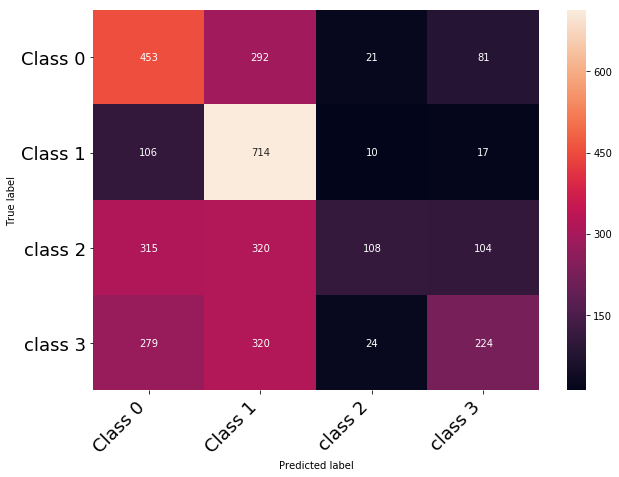

In [298]:
conf_mat = confusion_matrix(y_true=labels, y_pred=grids2['xgboost'].predict(X_train_down))
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1', 'class 2', 'class 3'])

In [608]:
xgb2 = XGBClassifier(
    max_depth=3, learning_rate=0.03162277660168379,
    n_estimators=80, objective='multi:softprob')
xgb2.fit(X_train_down, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03162277660168379,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=80, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [467]:
y_train_down_pred = xgb.predict(X_train_down)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [479]:
xgb.score(X_train_down, y_train_down)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.45306965761511214

Use hard prediction: 0.436245572609209 <br>
Use soft prediction: 0.45306965761511214 <br>


In [484]:
y_train_down_pred2 = xgb.predict_proba(X_train_down)

In [485]:
y_train_down_pred2

array([[0.2801723 , 0.14704494, 0.2843211 , 0.28846171],
       [0.2794787 , 0.16052158, 0.27718994, 0.28280976],
       [0.30200747, 0.1856129 , 0.2364509 , 0.27592877],
       ...,
       [0.3297953 , 0.06840462, 0.2915462 , 0.31025386],
       [0.16597585, 0.5686647 , 0.0644317 , 0.2009277 ],
       [0.33622435, 0.06916829, 0.29515448, 0.2994529 ]], dtype=float32)

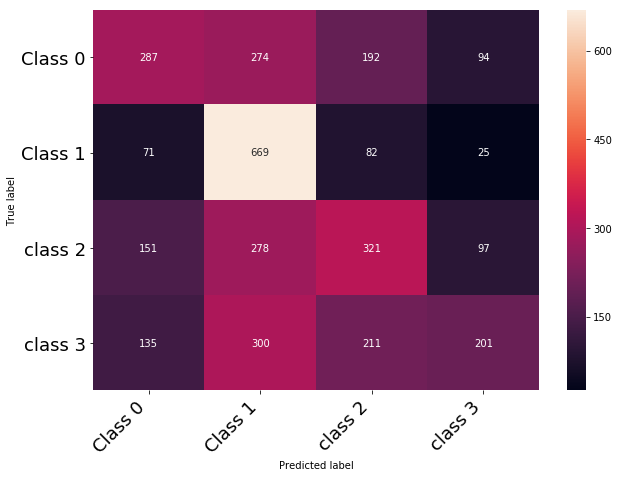

In [482]:
conf_mat = confusion_matrix(y_true=y_train_down, y_pred=y_train_down_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1', 'class 2', 'class 3'])

In [483]:
accuracy_score(y_train_down, y_train_down_pred2)

0.45306965761511214

## Upsampling

In [1008]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_2nd,y_mul)

In [1009]:
pd.DataFrame(y_smoted)[0].value_counts()

NDF      9303
NorAM    9303
Other    9303
EU       9303
Name: 0, dtype: int64

In [1010]:
models = [
          ('xgboost', XGBClassifier),
         ]

param_choices = [
    {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['multi:softprob']
    },
]

grids3 = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_smoted, y_smoted)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids3[name] = grid

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py

KeyboardInterrupt: 

## Build a result required by competition

In [1110]:
X_train_2nd_pd = pd.DataFrame(X_train_2nd, columns=X_user_train_1.columns.tolist()+['predict_class0', 'predict_class1'], index=X_user_train_1.index)

In [1116]:
tmp = pd.DataFrame(y_user_train)
other_index = (tmp['country_destination']!='NDF') & (tmp['country_destination']!='US')
US_NDF_index = (tmp['country_destination']=='NDF') | (tmp['country_destination']=='US')

In [1118]:
X_train_other = X_train_2nd_pd.loc[other_index]
X_train_US_NDF = X_train_2nd_pd.loc[US_NDF_index]
y_train_other = y_user_train[other_index]
y_train_US_NDF = y_user_train.loc[US_NDF_index]

In [1136]:
rus = SMOTE()
X_train_smote, y_train_smote = rus.fit_sample(X_train_2nd, y_user_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1138]:
xgb3 = XGBClassifier( max_depth=5, learning_rate=0.03162277660168379,
    n_estimators=200, objective='multi:softprob',
    subsample=0.9, colsample_bytree=0.5, min_child_weight=5)
xgb3.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03162277660168379,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [1143]:
print (type(y_user_train))
print (y_user_train.shape)
print (type(X_train_2nd))
print (X_train_2nd.shape)

<class 'pandas.core.frame.DataFrame'>
(16008, 1)
<class 'numpy.ndarray'>
(16008, 146)


In [ ]:
test = pd.DataFrame(y_user_train)
test['country_destination'].value_counts()
other_index = [(test['country_destination']!='NDF') & (test['country_destination']!='US')]
US_NDF_index = [(test['country_destination']=='NDF') | (test['country_destination']=='US')]


X_train_other = X_train_2nd[other_index]
X_train_US_NDF = X_train_2nd[US_NDF_index]
y_train_other = y_user_train[(test['country_destination']!='NDF') & (test['country_destination']!='US')]
y_train_US_NDF = y_user_train[(test['country_destination']=='NDF') | (test['country_destination']=='US')]

rus = SMOTE()
X_train_smote2, y_train_smote2 = rus.fit_sample(X_train_other, y_train_other)
X_train_smote2 = np.concatenate((X_train_smote, X_train_2nd))
y_train_smote2 = np.concatenate((y_train_smote.reshape(-1,1), np.array(y_train_US_NDF)))

In [1097]:
rus = SMOTE()
X_train_smote, y_train_smote = rus.fit_sample(X_train_2nd, y_user_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1122]:
X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_2nd_pd.columns)

In [1127]:
#X_train_mode = np.concatenate((X_train_smote, X_train_US_NDF))
y_train_smote = np.concatenate((y_train_smote.reshape(-1,1), np.array(y_train_US_NDF)))

In [1090]:
xgb3 = XGBClassifier( max_depth=5, learning_rate=0.03162277660168379,
    n_estimators=200, objective='multi:softprob',
    subsample=0.9, colsample_bytree=0.5, min_child_weight=5)
xgb3.fit(X_train_smote, y_train_smote)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03162277660168379,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [1146]:
with open('./data/model/stage2_xgboost.pkl', 'wb') as picklefile:
    pickle.dump(xgb3, picklefile)

In [1139]:
print ('Accuracy score is', xgb3.score(X_train_2nd, y_user_train))
y_train_down_pred3 = xgb3.predict(X_train_2nd)
y_train_down_pred3_soft = xgb3.predict_proba(X_train_2nd)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy score is 0.6251874062968515


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


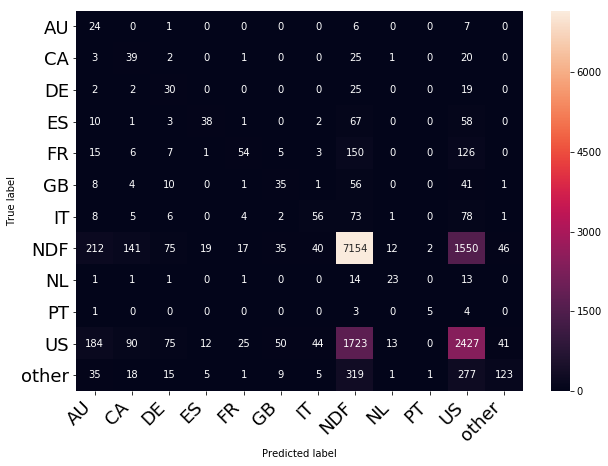

In [1140]:
conf_mat = confusion_matrix(y_true=y_user_train, y_pred=y_train_down_pred3)
cm = print_confusion_matrix(conf_mat, sorted(y_user_train['country_destination'].unique().tolist()))

In [1147]:
y_train_down_pred_soft = xgb3.predict_proba(X_train_down)

In [1154]:
pred = pd.DataFrame(y_train_down_pred_soft, index=range(X_train_down.shape[0]), columns=sorted(y_user_train['country_destination'].unique().tolist()))

In [1149]:
cols = pred.columns
ref = np.argsort(pred, axis=1)
result = []
for row in range(pred.shape[0]):
    final = [cols[i] for i in ref.iloc[row,:]][-1:-6:-1]
    result.append(final)

In [559]:
sum=0
for i in range(2):
    sum += (2**match[i]-1)/np.log2(i+1+1)

In [ ]:
cols = pred.columns
ref = np.argsort(pred, axis=1)
result = []
for row in range(pred.shape[0]):
    final = [cols[i] for i in ref.iloc[row,:]][-1:-6:-1]
    result.append(final)

In [1161]:
y_train_down_pred3_soft.shape
y_user_train

(16008, 1)

In [1162]:
pred = y_train_down_pred3_soft
real = y_user_train

In [1157]:
cols = pred.columns
ref = np.argsort(pred, axis=1)
result = []
for row in range(pred.shape[0]):
    final = [cols[i] for i in ref.iloc[row,:]][-1:-6:-1]
    result.append(final)
    match = [int(x == real[row]) for x in pred[row]]

In [1176]:
final = [cols[i] for i in ref.iloc[0,:]][-1:-6:-1]
final

['NDF', 'AU', 'US', 'ES', 'DE']

In [1177]:
#[cols[i] for i in ref.iloc[0,:]][-1:-6:-1]
match = [int(x == real.iloc[0,0]) for x in final]
#real.iloc[0,0]
match

[1, 0, 0, 0, 0]

In [1184]:
def get_score(pred, real):

    cols = pred.columns
    ref = np.argsort(pred, axis=1)
    result = []
    score = 0
    for row in range(pred.shape[0]):
        final = [cols[i] for i in ref.iloc[row,:]][-1:-6:-1]
        result.append(final)
        match = [int(x == real.iloc[row,0]) for x in final]
        sum=0
        for i in range(5):
            sum += (2**match[i]-1)/np.log2(i+1+1)
        #print ("real:", real.iloc[row,0], "predicted:", final, "score:", sum  )
        score += sum
        
    return result, score/len(pred)

In [1192]:
pred.shape

(111636, 12)

In [1193]:
pred = pd.DataFrame(y_train_down_pred3_soft, columns=sorted(y_user_train['country_destination'].unique().tolist()))
result, score = get_score(pred, y_user_train)

In [1196]:
print (score)

0.821633166762153


## Check test performance

In [994]:
X_user_test, _ = impute_age(X_user_test, train_age_mode)
X_user_test, _ = custom_dummify(X_user_test, 0.005, user_train_cols)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [995]:
index = (X_user_test.columns != X_user_train.columns)
X_user_train.columns[index]

Index([], dtype='object')

In [996]:
session_test, _ = impute_mode(session_test, 'action', 'action_type', action_type_mode)
session_test, _ = impute_mode(session_test, 'action', 'action_detail', action_detail_mode)
session_test, _ = impute_mode(session_test, 'action', 'secs_elapsed', action_secs_mode)
session_test.fillna("catch-all", inplace=True)
session_stats_test = get_session_cat_stats(X_user_test, session_test)

In [997]:
X_user_test_1 = deepcopy(X_user_test)
X_user_test_1 = X_user_test_1.merge(session_stats_test, how='left', left_index=True, right_index=True)
X_user_test_1 = get_session_continous_stats(X_user_test_1, session_test)
X_user_test_1.fillna(0.0, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [998]:
index = (X_user_test_1.columns != X_user_train_1.columns)
X_user_test_1.columns[index]

Index([], dtype='object')

In [999]:
X_user_train_1.columns[index]

Index([], dtype='object')

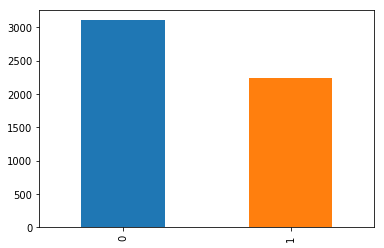

In [1000]:
y_bin_test = deepcopy(y_user_test)
y_bin_test['booking'] = 1 - (y_bin_test['country_destination'] == 'NDF').astype('int')
y_bin_test.drop(['country_destination'], axis=1, inplace=True)
y_test=y_bin_test
y_test['booking'].value_counts().plot('bar')

In [1001]:
X_test_imputed_scaled = ssX.transform(X_user_test_1)

In [1002]:
y_test_pred = grids['logistic'].predict(X_test_imputed_scaled)
y_test_pred_soft = grids['logistic'].predict_proba(X_test_imputed_scaled)
xgb.score(X_test_imputed_scaled, y_test)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7026419336706015

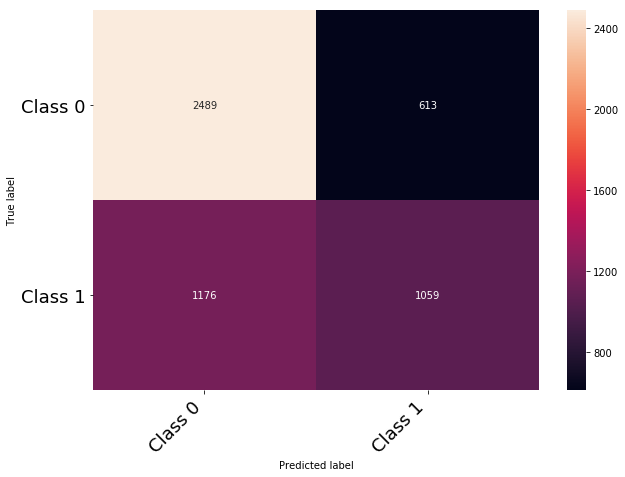

In [1003]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

In [1197]:
X_test_stage2 = deepcopy(X_test_imputed_scaled)
X_test_2nd = np.append(X_test_stage2, y_test_pred_soft, axis=1)

In [ ]:
print ('Accuracy score is', xgb3.score(X_train_2nd, y_user_train))
y_train_down_pred3 = xgb3.predict(X_train_2nd)
y_train_down_pred3_soft = xgb3.predict_proba(X_train_2nd)

In [1201]:
print (X_train_2nd.shape)
print (X_test_2nd.shape)

(16008, 146)
(5337, 146)


In [1202]:
print ('Accuracy score is', xgb3.score(X_test_2nd, y_user_test))
y_test_pred3 = xgb3.predict(X_test_2nd)
y_test_pred3_soft = xgb3.predict_proba(X_test_2nd)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy score is 0.5726063331459621


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


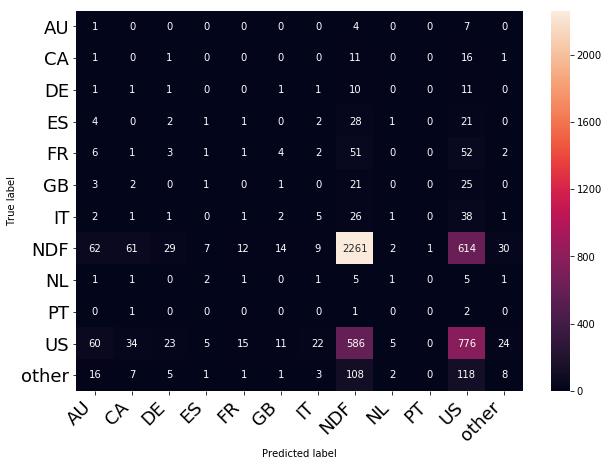

In [1204]:
conf_mat = confusion_matrix(y_true=y_user_test, y_pred=y_test_pred3)
cm = print_confusion_matrix(conf_mat, sorted(y_user_test['country_destination'].unique().tolist()))

In [1207]:
pred_test = pd.DataFrame(y_test_pred3_soft, columns=sorted(y_user_train['country_destination'].unique().tolist()))
result, score_test = get_score(pred_test, y_user_test)

In [1208]:
print (score_test)

0.772012413040384
